# Countsort stats

With Countsort implemented in `src/lib.rs` and a nice command-line interface in `src/main.rs`, and the PyO3 work done (thanks to [this great tutorial](http://saidvandeklundert.net/learn/2021-11-18-calling-rust-from-python-using-pyo3/) by Said van de Klundert) and [this great StackExchange post](https://stackoverflow.com/questions/57756927/rust-modules-confusion-when-there-is-main-rs-and-lib-rs) by zrzka, we can do our stats and plotting.

This implements **Countsort**, a linear-time sorting algorithm that sorts `n` values from an alphabet of size `k` in $O(n + k)$ space and time. This Rust module implements it for unsigned integers with `w` bits, so $k = 2^w$.

Let's test the assertion: **Is countsort really linear time?** We'll plot for exponentially-spaced values of $n$ and $k$, across several trials.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # optional, for plotting progress

import countsortmodule

We have `countsortmodule` which provides `countsort_timing_python(n, w)`, where
    - `n` is the number of elements to sort, and
    - `w` is the number of bits in the unsigned integer. So, we sort elements in range `[0, 2^w)`.

**Warning that this takes about $8 * (n + 2^w)$ bytes of RAM.** For large n or w, this can be significant.

## 1. Run experiments

Note: This will run much slower than the equivalent in Rust. Only the runtime of the sort if recorded, not the overhead of PyO3 or of generating the values.

For example, consider these parameters, this runs in less than 10 seconds per trial for the equivalent rust, but about 1 minute in my machine.

```
Ns = [2**ii for ii in [6, 8, 10, 12, 14, 16, 18, 20, 22, 24]]
Ws = [8, 12, 16, 20, 24]
T = 8
```


In [2]:
Ns = np.array([2**ii for ii in [6, 8, 10, 12, 14, 16, 18, 20, 22, 24]])
Ws = np.array([8, 12, 16, 20, 24])
T = 8

In [3]:
# Run our experiments here.
# Results are measured in nanoseconds

results = np.array(
    [
        [
            [
                countsortmodule.countsort_timing_python(n, w)
                for w in Ws
            ]
            for n in Ns
        ]
        # replace with `for t in range(T)` if you don't want TQDM
        for t in tqdm(range(T))
    ]
)


100%|██████████████████████████████████████████████████████████████████████| 8/8 [07:12<00:00, 54.01s/it]


In [4]:
assert results.shape == (T, len(Ns), len(Ws))
print(results.shape)

(8, 10, 5)


In [5]:
np.save("results.npy", results)

## 2. Plot results

Let's plot, for each w, average runtime against w. We should expect:

    - A linear relation between n and runtime.
    - A linear relation between w and runtime.

This will become even more evident when we plot on a log curve.

In [6]:
results = np.load("results.npy")

In [7]:
results_avg = results.mean(axis=0)
results_std = results.std(axis=0)

print(results_avg.shape)

(10, 5)


In [8]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

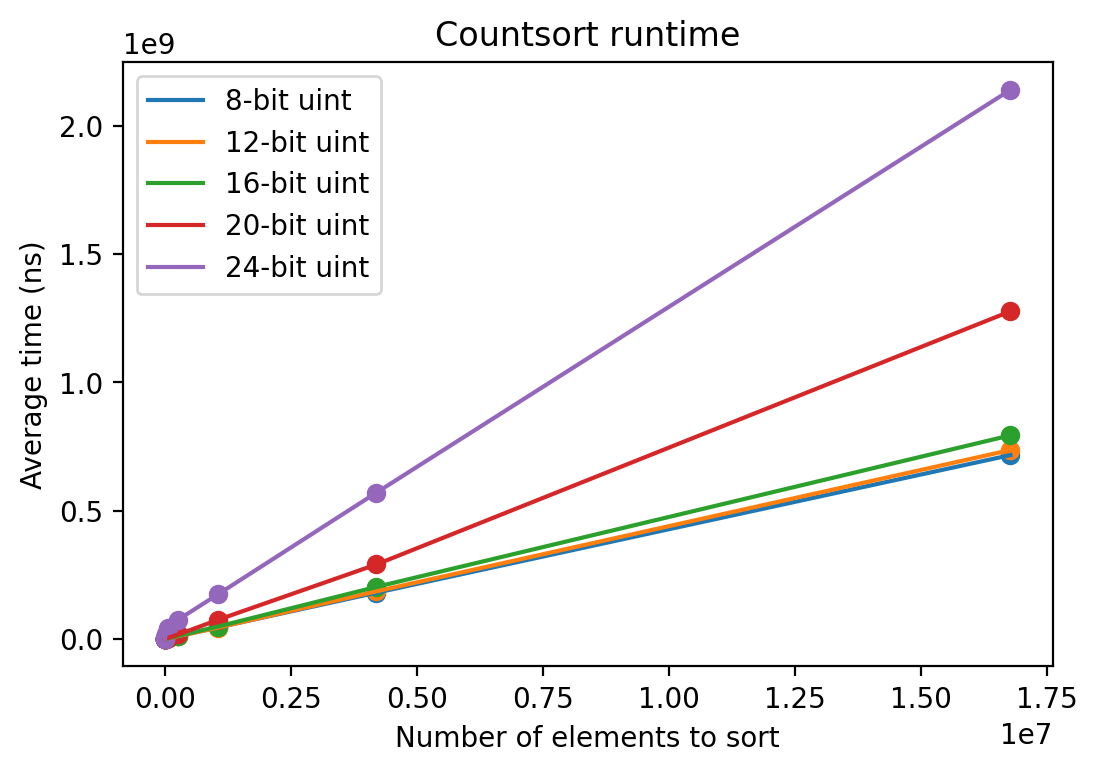

In [9]:
# Let's look at a normal sort
for ii in range(len(Ws)):
    plt.scatter(Ns, results_avg[:, ii])
    plt.plot(Ns, results_avg[:, ii])

plt.xlabel("Number of elements to sort")
plt.ylabel("Average time (ns)")

plt.title("Countsort runtime")
plt.legend([f"{w}-bit uint" for w in Ws])

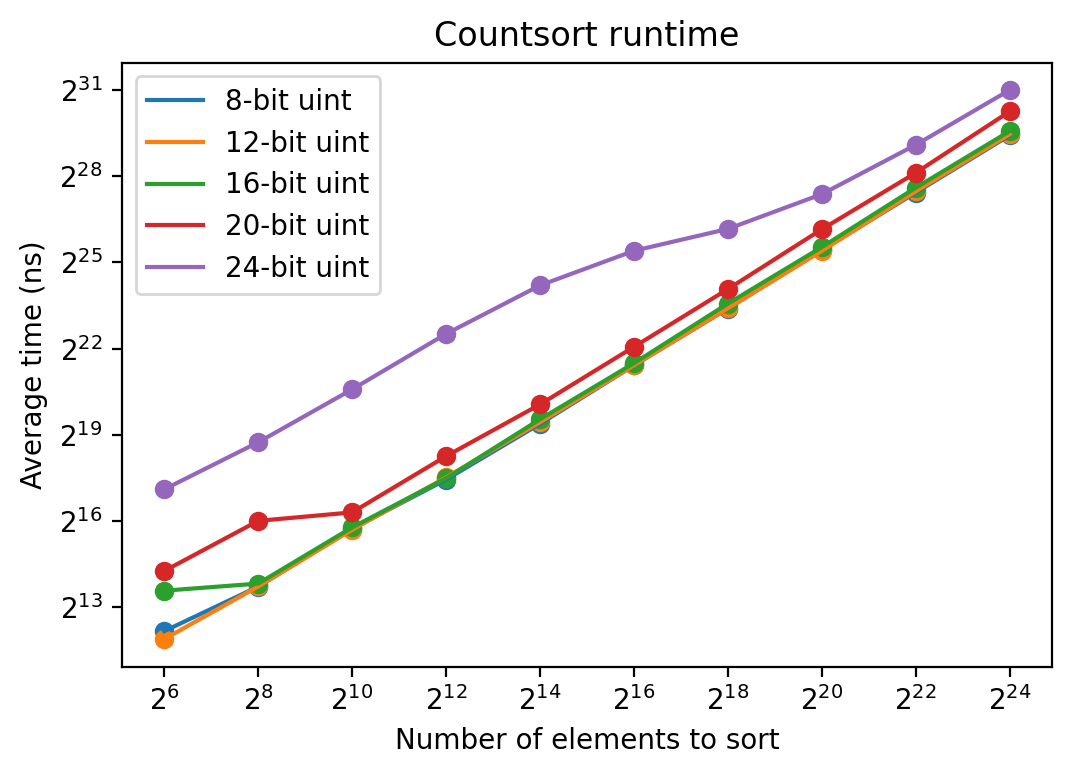

In [10]:
# Let's look at the log range
for ii in range(len(Ws)):
    plt.scatter(Ns, results_avg[:, ii])
    plt.plot(Ns, results_avg[:, ii])

plt.yscale('log', base=2)
plt.xscale('log', base=2)

plt.xlabel("Number of elements to sort")
plt.ylabel("Average time (ns)")
plt.xticks(Ns)

plt.title("Countsort runtime")
plt.legend([f"{w}-bit uint" for w in Ws])

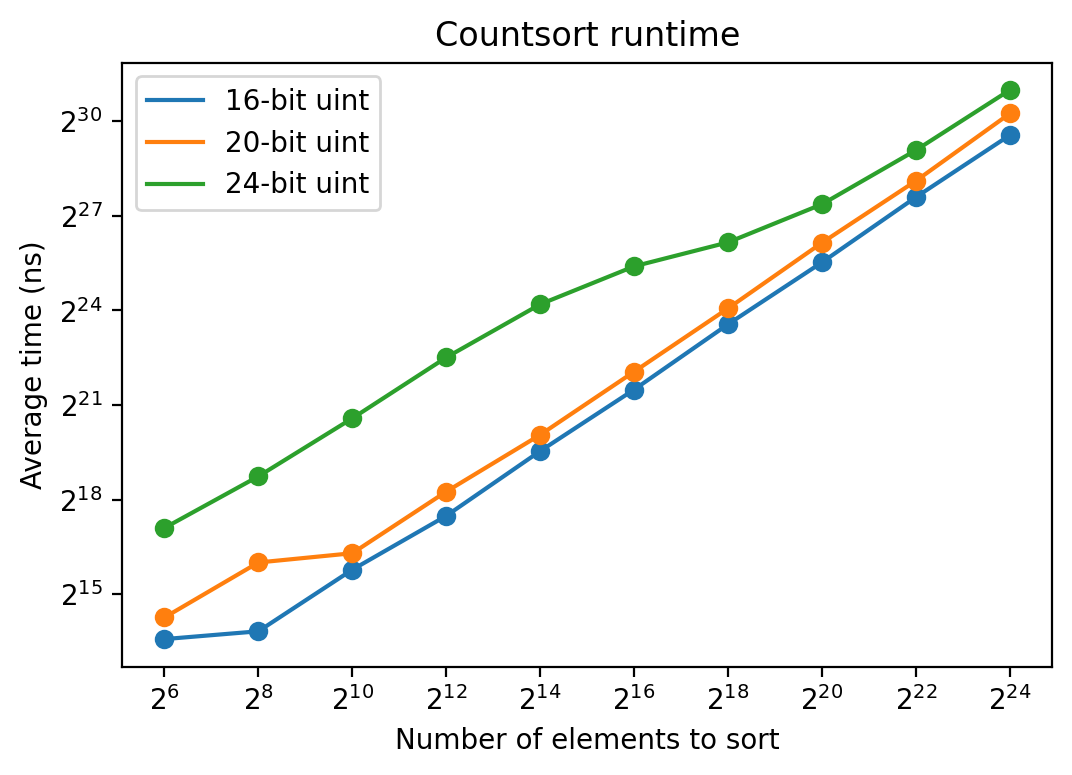

In [11]:
# 8, 12, and 16 overlap a lot. Let's look at 16, 20, 24
for ii in [2, 3, 4]:
    plt.scatter(Ns, results_avg[:, ii])
    plt.plot(Ns, results_avg[:, ii])

plt.yscale('log', base=2)
plt.xscale('log', base=2)

plt.xlabel("Number of elements to sort")
plt.ylabel("Average time (ns)")
plt.xticks(Ns)

plt.title("Countsort runtime")
plt.legend([f"{w}-bit uint" for w in Ws[[2, 3, 4]]])